In [45]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt


(train_ds, test_ds), ds_info = tfds.load('cifar10', split=['train', 'test'], as_supervised=True, with_info=True)
BATCH_SIZE = 64

#print(ds_info)

In [46]:
## 1.1 Prep dataset
def preprocessing_cifar10(image, label):
    image = tf.cast(image, tf.float32) / 128 - 1
    label = tf.one_hot(label, depth=10)
    return image, label

train_ds = train_ds.map(preprocessing_cifar10)
train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE).prefetch(2)



In [47]:
def try_model(model, ds):
  for x, t in ds.take(5):
    y = model(x)



Text(0.5, 1.0, 'Label: 0')

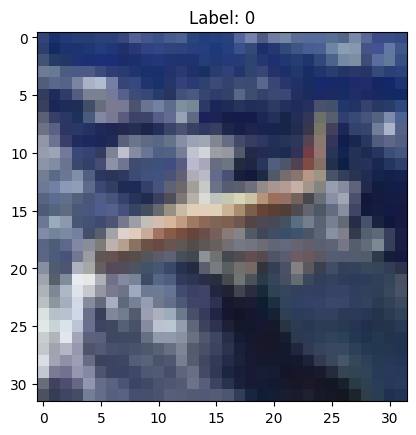

In [48]:
## Visualization
# ectract batch of smaples
sample_batch = next(iter(train_ds))
# unpack batch
sample_image, sample_label = sample_batch

# right now normalized to the range [-1, 1], so rescale it to [0, 1] for visualization purposes
plt.imshow((sample_image[0] + 1) / 2)
plt.title(f"Label: {np.argmax(sample_label[0])}")
#plt.axis("off")

In [49]:
## 1.2 Creation of CNN Model

from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten

class MyCNN(tf.keras.Model):
  def __init__(self):
    super(MyCNN, self).__init__()

    self.convlayer1 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(32, 32, 3))
    self.convlayer2 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')
    self.pooling = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)

    self.convlayer3 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')
    self.convlayer4 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')
    self.global_pool = tf.keras.layers.GlobalAvgPool2D()

    self.out = tf.keras.layers.Dense(10, activation='softmax')


  def call(self, x):
    x = self.convlayer1(x)
    x = self.convlayer2(x)
    x = self.pooling(x)
    x = self.convlayer3(x)
    x = self.convlayer4(x)
    x = self.global_pool(x)
    x = self.out(x)
    return x



cifar_cnn = MyCNN()
try_model(cifar_cnn, train_ds)


In [20]:
# ## 1.3 Training


# #@tf.function
# def train_loop(train_ds, NUM_EPOCHS, LR, loss_function, optimizer):
#     model = MyCNN()
#     # # build model by calling it on a batch of data
#     # sample_batch = next(iter(train_ds))
#     # model.build(input_shape=sample_batch[0].shape)

#     #print(model.summary())

#     # define metric
#     train_acc_metric = tf.keras.metrics.CategoricalAccuracy()
#     train_losses_metric = tf.keras.metrics.Mean()

#     for epoch in range(NUM_EPOCHS):
#         print(f"Epoch {epoch}:")

#         # reset accuracy metric at the beginning of each epoch
#         train_acc_metric.reset_states()

#         # TRAIN set
#         for x, t in train_ds:
#             with tf.GradientTape() as tape:
#                 pred = model(x)
#                 l = loss_function(t, pred)

#             gradients = tape.gradient(l, model.trainable_variables)
#             optimizer.apply_gradients(zip(gradients, model.trainable_variables))

#             # update accuracy metric
#             train_acc_metric.update_state(t, pred)
#             train_losses_metric.update_state(l)

#         # calculate accuracy at the end of each epoch
#         train_accuracy = train_acc_metric.result().numpy() #numerical value of the accuracy for printing
#         print(f"Training Accuracy: {train_accuracy}")

#     # Optionally, return or save the trained model
#     return model


In [50]:

def train_loop(train_ds, test_ds, NUM_EPOCHS, LR, loss_function, optimizer):
    model = MyCNN()

    # Build the model by calling it on a batch of data
    # sample_batch = next(iter(train_ds))
    # model.build(input_shape=sample_batch[0].shape)

    train_accuracy_metric = tf.keras.metrics.CategoricalAccuracy()
    val_accuracy_metric = tf.keras.metrics.CategoricalAccuracy()
    train_losses_metric = tf.keras.metrics.Mean()
    val_losses_metric = tf.keras.metrics.Mean()
# for plotting:
    train_accuracies, val_accuracies = [], []
    train_losses, val_losses = [], []

    for epoch in range(NUM_EPOCHS):
        print(f"Epoch {epoch + 1} of {NUM_EPOCHS}:")

        # Reset metrics at the beginning of each epoch
        train_accuracy_metric.reset_states()
        val_accuracy_metric.reset_states()
        train_losses_metric.reset_states()
        val_losses_metric.reset_states()

        # TRAIN set
        for x_train, t_train in train_ds:
            with tf.GradientTape() as tape:
                train_pred = model(x_train)
                train_loss = loss_function(t_train, train_pred)

            gradients = tape.gradient(train_loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

            # Update training metrics
            train_accuracy_metric.update_state(t_train, train_pred)
            train_losses_metric.update_state(train_loss)

        # Calculate training metrics at the end of each epoch
        train_accuracy = train_accuracy_metric.result().numpy()
        train_loss = train_losses_metric.result().numpy()
        print(f"Training Accuracy: {train_accuracy}, Training Loss: {train_loss}")

        # Save training metrics for visualization
        train_accuracies.append(train_accuracy)
        train_losses.append(train_loss)

        # TEST set
        for x_val, t_val in test_ds:
            val_pred = model(x_val)
            val_loss = loss_function(t_val, val_pred)

            # Update validation metrics
            val_accuracy_metric.update_state(t_val, val_pred)
            val_losses_metric.update_state(val_loss)

        # Calculate validation metrics at the end of each epoch
        val_accuracy = val_accuracy_metric.result().numpy()
        val_loss = val_losses_metric.result().numpy()
        print(f"Validation/Test Accuracy: {val_accuracy}, Validation/Test Loss: {val_loss}")

        # Save validation metrics for visualization
        val_accuracies.append(val_accuracy)
        val_losses.append(val_loss)

    # Plot training and validation metrics
    epochs_range = range(1, NUM_EPOCHS + 1)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
    plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_losses, label='Training Loss')
    plt.plot(epochs_range, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.show()

In [52]:
NUM_EPOCHS = 15
LR = 0.000001
loss_function = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
optimizer = tf.keras.optimizers.Adam(learning_rate=LR)


#call train loop
trained_model = train_loop(train_ds, test_ds, NUM_EPOCHS, LR, loss_function, optimizer)

Epoch 1 of 15:
Training Accuracy: 0.0997999981045723, Training Loss: 2.3053224086761475


ValueError: ignored

In [ ]:
# possible adjustments

# @tf.function
# kein Softmax?? ->then from_logits=True